In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import warnings

warnings.filterwarnings("ignore")

we use a dataset called AqSolDB that has about 10,000 unique compounds with measured solubility in water (label). The dataset also includes molecular properties (features) that we can use for machine learning. The solubility measurement is solubility of the compound in water in units of log molarity.

We Begin by importing the data and visualising it

In [ ]:
soldata = pd.read_csv(
    "data/curated-solubility-dataset.csv"
)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


Exploratory Data Analysis:

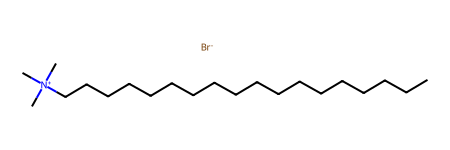

In [ ]:
# plot one molecule
mol = rdkit.Chem.MolFromInchi(soldata.InChI[0])
mol

<ipython-input-10-01d4ce4712e1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(soldata.Solubility)


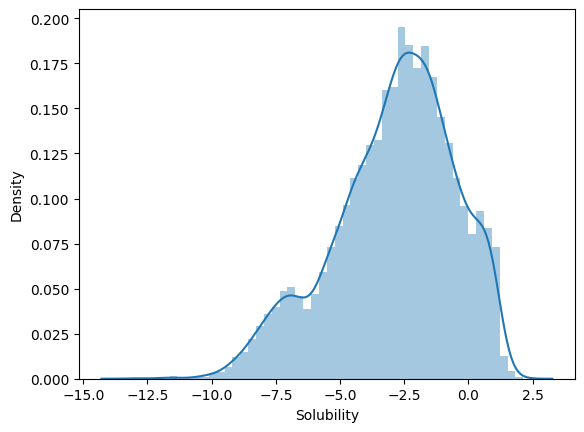

In [ ]:
# Check the solubility distriubtion
sns.distplot(soldata.Solubility)
plt.show()

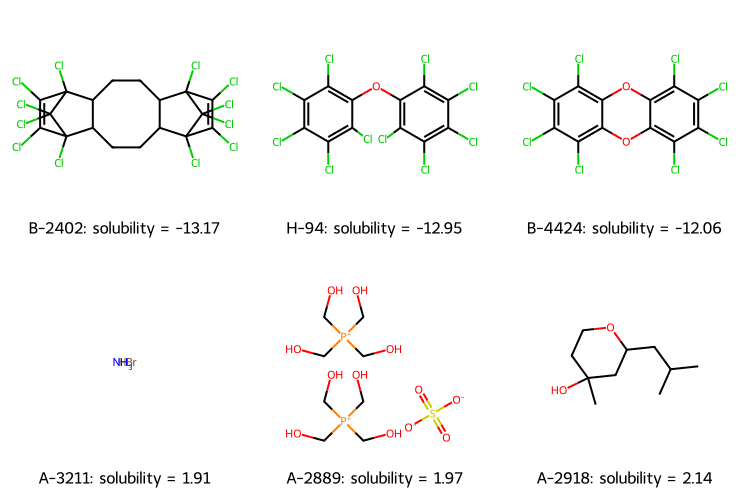

In [ ]:
# get 3 lowest and 3 highest solubilities
soldata_sorted = soldata.sort_values("Solubility")
extremes = pd.concat([soldata_sorted[:3], soldata_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [
    f"{x.ID}: solubility = {x.Solubility:.2f}" for x in extremes.itertuples()
]

# now plot them on a grid
extreme_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in extremes.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    extreme_mols, molsPerRow=3, subImgSize=(250, 250), legends=legend_text
)

We can see that the highly-chlorinated compounds have the lowest solubility and ionic compounds have higher solubility.
But we can see that A-2918 looks like an outlier. Also can we really compare NH3 to organic compounds?

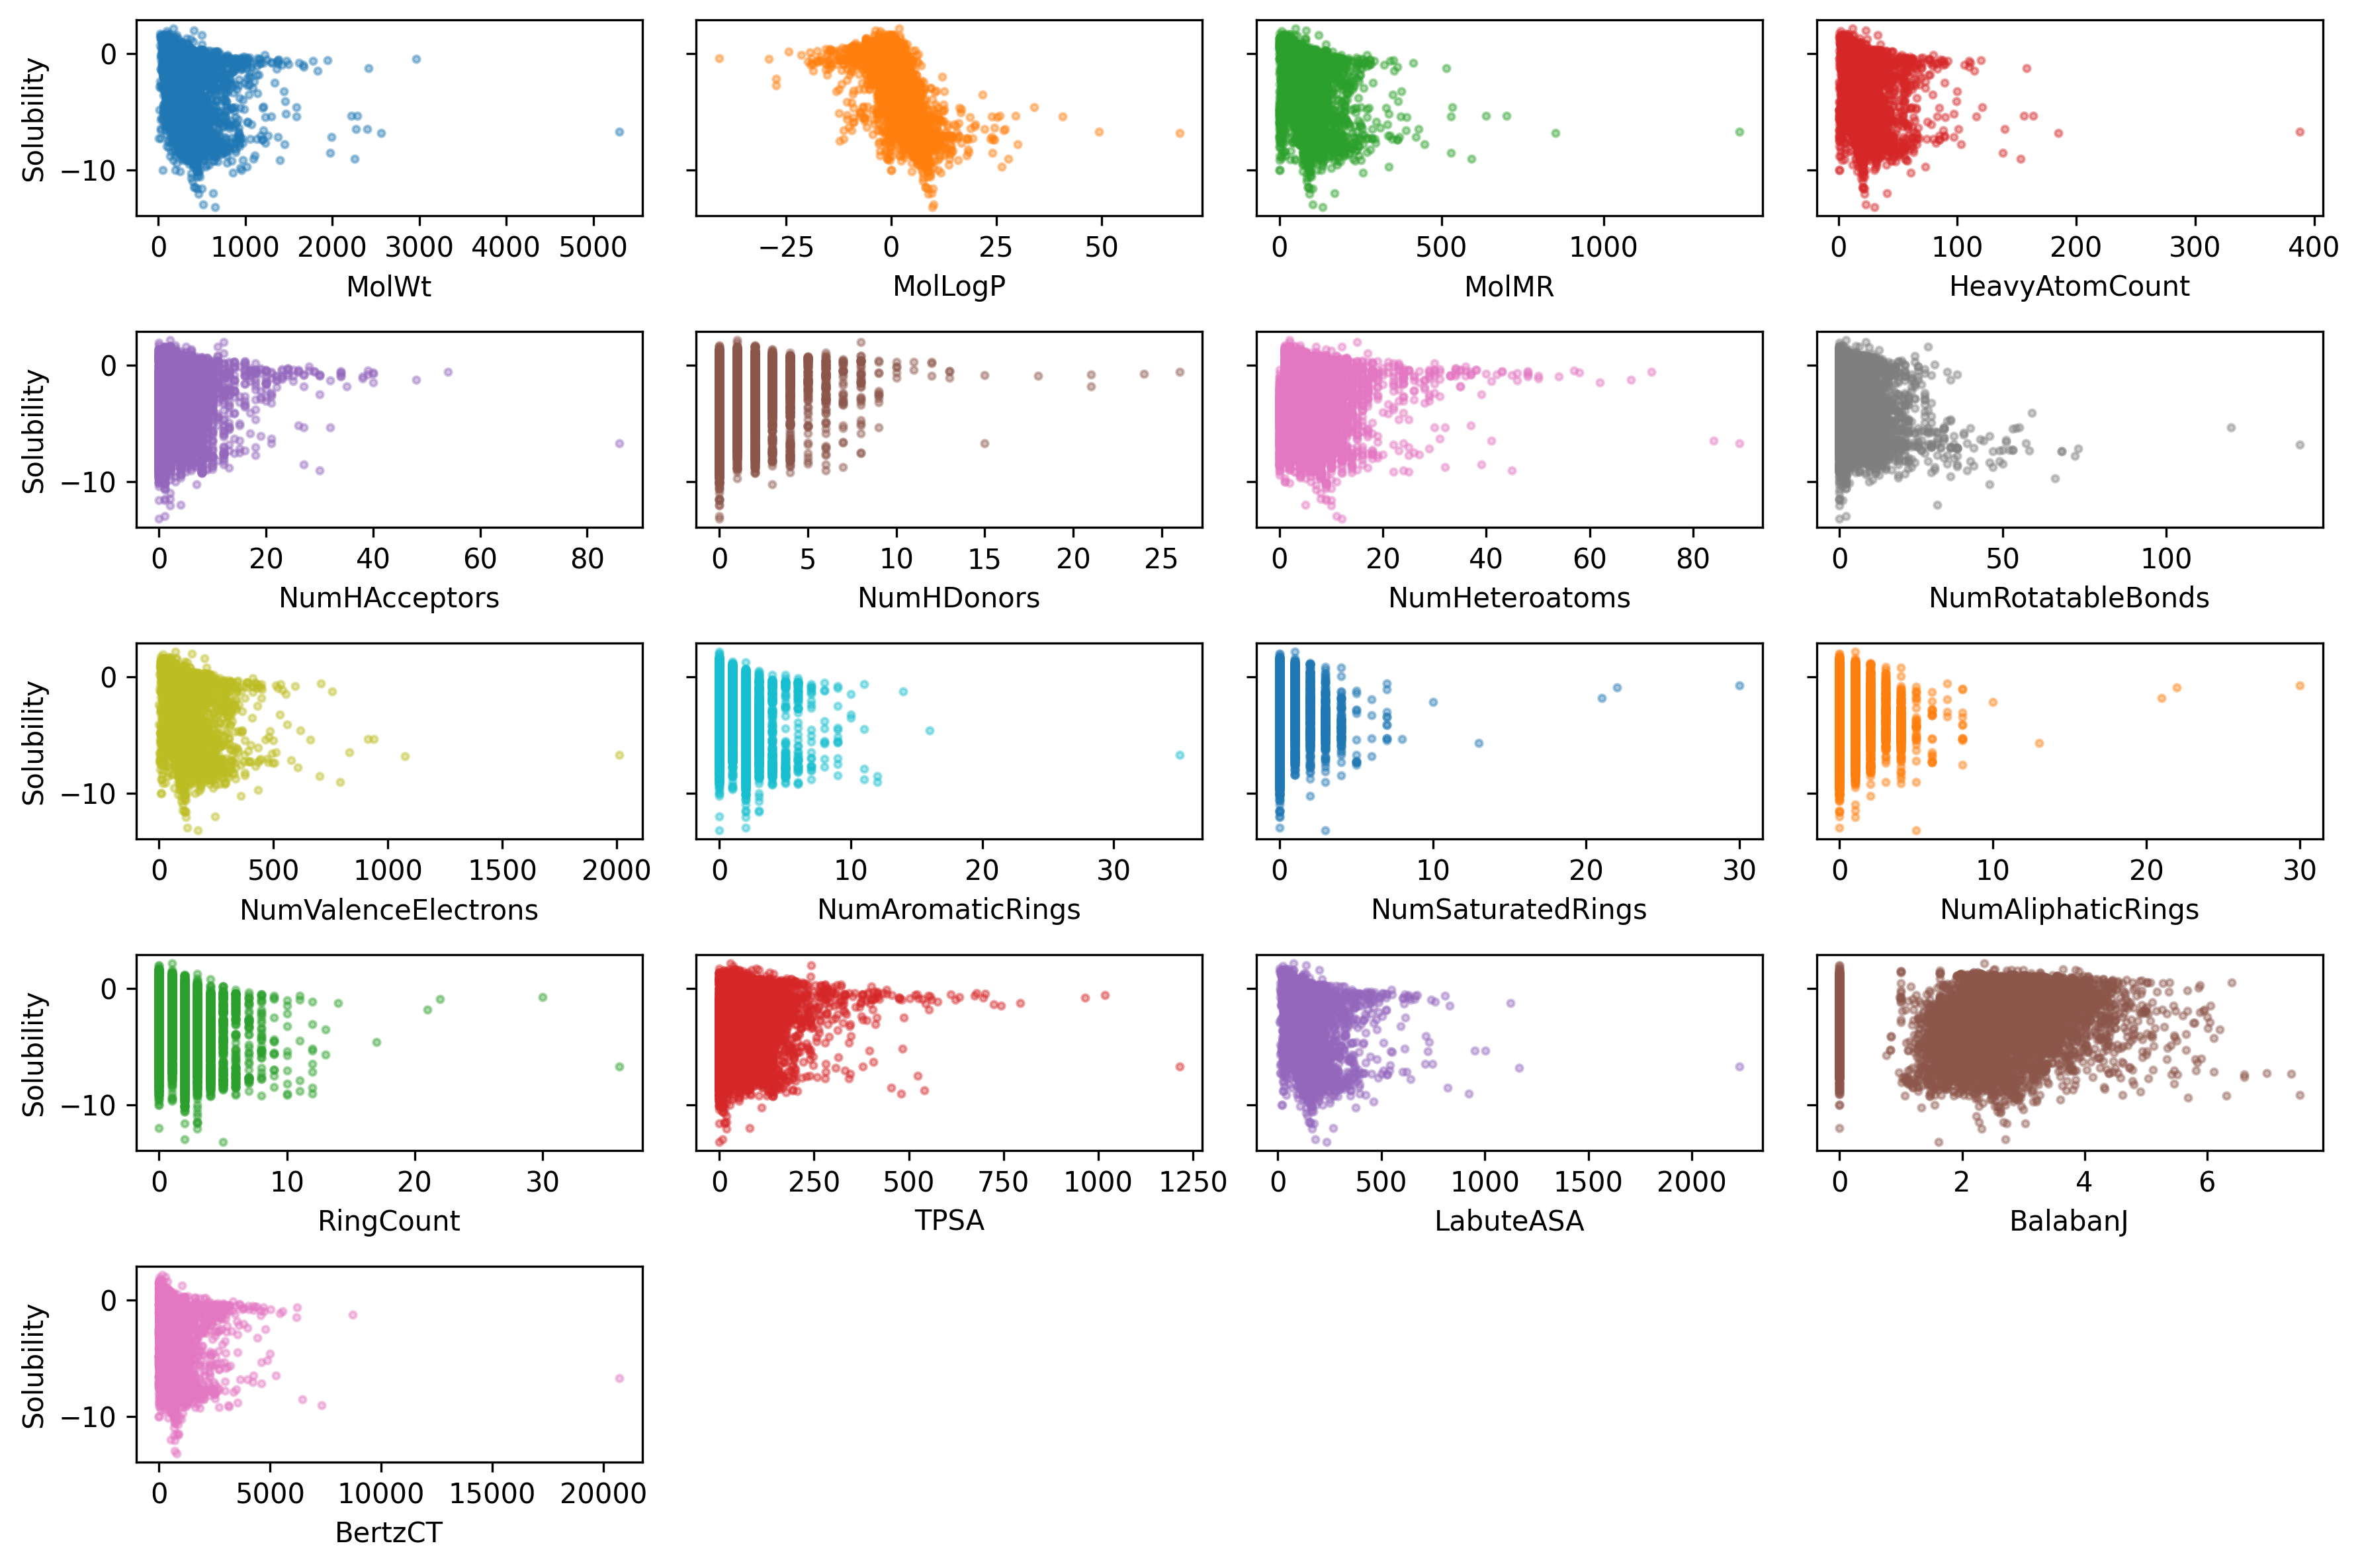

In [ ]:
# Feature correlations with respect to solubility

features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        soldata[n], soldata.Solubility, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

We can see that molecular weight or hydrogen bond numbers seem to have little correlation. MolLogP, which is a calculated descriptor related to solubility, does correlate well. We can also see that some of these features have low variance, meaning the value of the feature changes little or not at all for many data points (e.g., “NumHDonors”)

We begin with defining a simple regression model without using any external libraries:

In [ ]:
def linear_model(x, w, b):
    return jnp.dot(x, w) + b

# convert data into features, labels
features = soldata.loc[:, feature_names].values
labels = soldata.Solubility.values

feature_dim = features.shape[1]

# initialize our paramaters
w = np.random.normal(size=feature_dim)
b = 0.0


# define loss
def loss(y, labels):
    return jnp.mean((y - labels) ** 2)


# test it out
y = linear_model(features, w, b)
loss(y, labels)

Array(866934.9, dtype=float32)

We begin with a terrible loss. But that's what is expected from a simple model.
We will now compute gradients and find out the weights and bias

In [ ]:
# compute gradients
def loss_wrapper(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss(y, labels)

# gradient calculation with jax
loss_grad = jax.grad(loss_wrapper, (0, 1))

# test it out
loss_grad(w, b, (features, labels))

(Array([-5.7859519e+05, -3.8387253e+03, -1.4456364e+05, -3.8378285e+04,
        -8.0267236e+03, -2.0484473e+03, -1.1530879e+04, -8.8032139e+03,
        -2.0306919e+05, -2.7442417e+03, -5.4157654e+02, -9.4603754e+02,
        -3.6902864e+03, -1.3611081e+05, -2.3982795e+05, -2.7446592e+03,
        -1.3231960e+06], dtype=float32),
 Array(-1352.8755, dtype=float32, weak_type=True))

We will now minimize the gradients over a few epochs (10). We take the learning rate as 1e-6

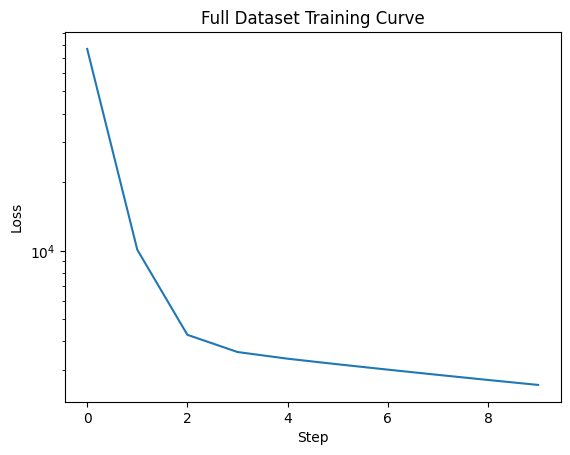

In [ ]:
loss_progress = []
eta = 1e-6
data = (features, labels)
for i in range(10):
    grad = loss_grad(w, b, data)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss_wrapper(w, b, data))
plt.plot(loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Full Dataset Training Curve")
plt.show()

We now do batching of the data and introduce stochastic gradient descent. We use a batch size of 32.

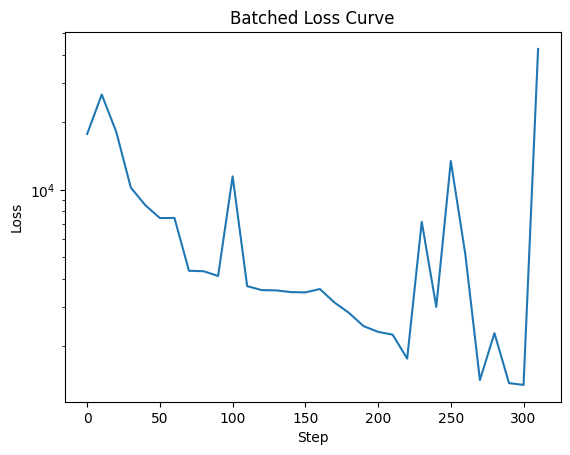

In [ ]:
# initialize our paramaters
# to be fair to previous method
w = np.random.normal(size=feature_dim)
b = 0.0

loss_progress = []
eta = 1e-6
batch_size = 32
N = len(labels)  # number of data points
data = (features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size

# the -1 means that numpy will compute
# what that dimension should be
batched_features = features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
# to make it random, we'll iterate over the batches randomly
indices = np.arange(new_N // batch_size)
np.random.shuffle(indices)
for i in indices:
    # choose a random set of
    # indices to slice our data
    grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
    w -= eta * grad[0]
    b -= eta * grad[1]
    # we still compute loss on whole dataset, but not every step
    if i % 10 == 0:
        loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 10, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Batched Loss Curve")
plt.show()

The loss is less for SGD than the previous case.

We now standardize the data to bring the features on the same scale. It helps the learning rate to minimze the loss function smoothly.
We increase the learning rate to 1e-2

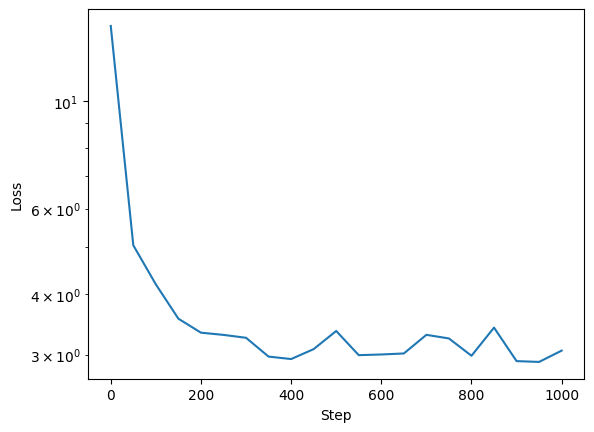

In [ ]:
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
std_features = (features - fmean) / fstd

# initialize our paramaters
# since we're changing the features
w = np.random.normal(scale=0.1, size=feature_dim)
b = 0.0


loss_progress = []
eta = 1e-2
batch_size = 32
N = len(labels)  # number of data points
data = (std_features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size
num_epochs = 3

# the -1 means that numpy will compute
# what that dimension should be
batched_features = std_features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
indices = np.arange(new_N // batch_size)

# iterate through the dataset 3 times
for epoch in range(num_epochs):
    # to make it random, we'll iterate over the batches randomly
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 50 == 0:
            loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 50, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.show()

We analyze the performance of our model

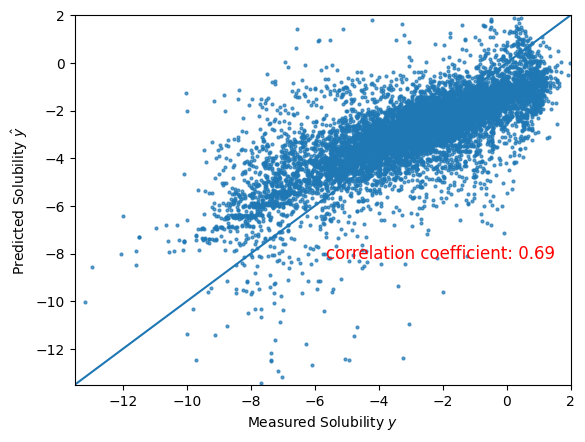

In [ ]:
predicted_labels = linear_model(std_features, w, b)

plt.plot([-100, 100], [-100, 100])
plt.scatter(labels, predicted_labels, s=4, alpha=0.7)
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.text(-2,-8, f'correlation coefficient: {np.round(np.corrcoef(labels, predicted_labels)[0, 1],2)} ', fontsize=12, ha='center', va='center', color='red')
plt.xlim(-13.5, 2)
plt.ylim(-13.5, 2)
plt.show()

We will now try to see the clusters of solubility data. We start by projecting our features into 2 dimensions

In [ ]:
# get down to 2 dimensions for easy visuals
embedding = sklearn.manifold.Isomap(n_components=2)

# only fit to every 25th point to make it fast
embedding.fit(std_features[::25, :])
reduced_features = embedding.transform(std_features)

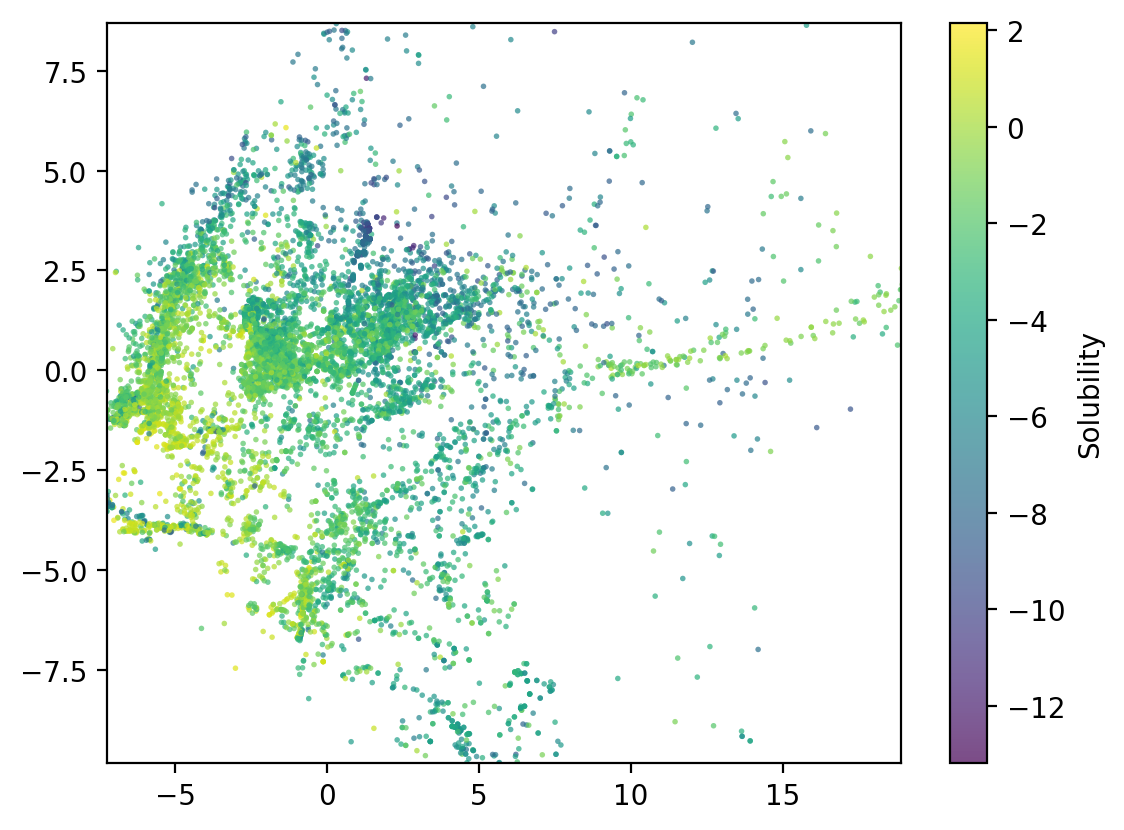

In [ ]:
# We zoom into the middle 99th percentile of the data since some of the points are extremely far away

xlow, xhi = np.quantile(reduced_features, [0.005, 0.995], axis=0)

plt.figure(dpi=200)
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=labels,
    edgecolors="none",
)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
cb = plt.colorbar()
cb.set_label("Solubility")
plt.show()

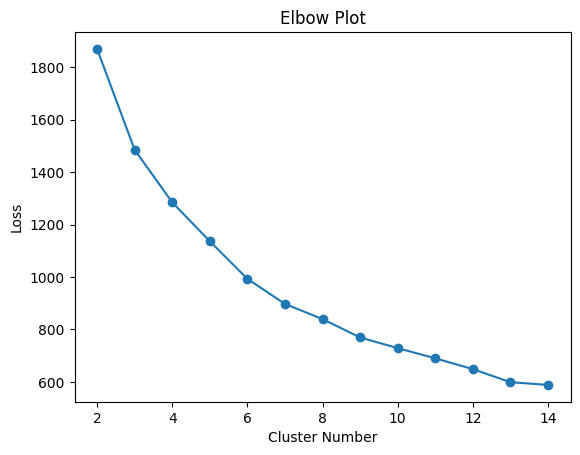

In [ ]:
# We make clusters using k-means clustering
# We plot the elbow plot to decide on the optimum number of clusters needed

# make an elbow plot
loss = []
cn = range(2, 15)
for i in cn:
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0)
    # use every 50th point
    kmeans.fit(std_features[::50])
    # we get score -> opposite of loss
    # so take -
    loss.append(-kmeans.score(std_features[::50]))

plt.plot(cn, loss, "o-")
plt.xlabel("Cluster Number")
plt.ylabel("Loss")
plt.title("Elbow Plot")
plt.show()

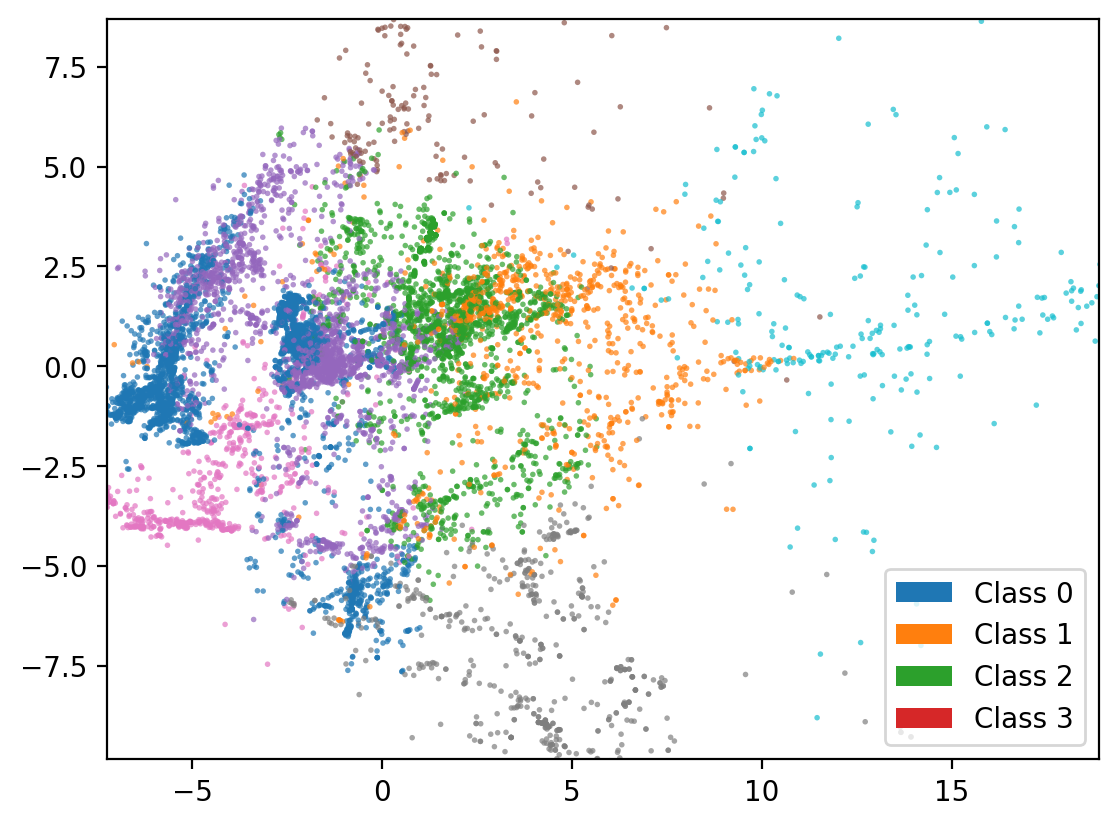

In [ ]:
# we take the cluster size to be 10 as we can see no significant improvement in elbow plot beyond that

# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=10, random_state=0)
kmeans.fit(std_features)

plt.figure(dpi=200)
point_colors = [f"C{i}" for i in kmeans.labels_]
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=point_colors,
    edgecolors="none",
)
# make legend
legend_elements = [
    plt.matplotlib.patches.Patch(
        facecolor=f"C{i}", edgecolor="none", label=f"Class {i}"
    )
    for i in range(4)
]
plt.legend(handles=legend_elements)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
plt.show()

To get insights into what the clusters really are, we can extract the mose centered data points (closest to cluster center) and consider them to be representative of the cluster

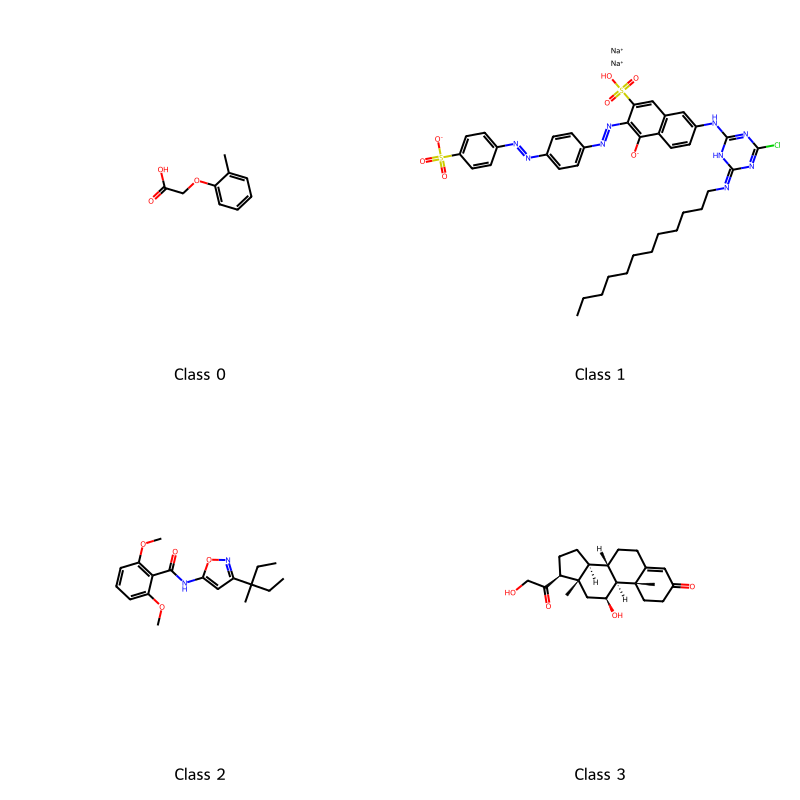

In [ ]:
# cluster - using whole features
# For the visualisation sake (properly fit in on screen), we take only 4 clusters

kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

cluster_center_idx = []
for c in kmeans.cluster_centers_:
    # find point closest
    i = np.argmin(np.sum((std_features - c) ** 2, axis=1))
    cluster_center_idx.append(i)
cluster_centers = soldata.iloc[cluster_center_idx, :]

legend_text = [f"Class {i}" for i in range(4)]
subImgSize = (400,400)

# now plot them on a grid
cluster_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in cluster_centers.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    cluster_mols, subImgSize=subImgSize, molsPerRow=2, legends=legend_text
)